<a href="https://colab.research.google.com/github/MohammadFaseeh/pdc_project/blob/main/PDC_Project_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!apt update
!apt install -y nvidia-cuda-toolkit
!apt install -y libopencv-dev python3-opencv

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
38 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InR

In [13]:
from google.colab import files
uploaded = files.upload()

Saving landscape.jpg to landscape (1).jpg
Saving text1.txt to text1 (1).txt


In [14]:
%%writefile encode_mpi.cu
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <opencv2/opencv.hpp>

using namespace cv;

__global__ void LSB(unsigned char *input, char *message, int offset, int total_bits) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < total_bits) {
        int global_i = offset + i;
        int bit_index = 7 - (global_i % 8);
        int char_index = global_i / 8;
        unsigned char bit = (message[char_index] >> bit_index) & 1;
        input[global_i] = (input[global_i] & ~1) | bit;
    }
}

void encodeMessageWithCUDA(Mat& image, char* message, int msg_len) {
    int total_bits = msg_len * 8;
    int img_size = image.rows * image.cols * image.channels();

    unsigned char *d_img;
    char *d_msg;

    cudaMalloc(&d_img, img_size);
    cudaMalloc(&d_msg, msg_len);
    cudaMemcpy(d_img, image.data, img_size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_msg, message, msg_len, cudaMemcpyHostToDevice);

    int size = 4; // Number of simulated MPI processes
    int threads = 256;

    for (int rank = 0; rank < size; ++rank) {
        int chunk = total_bits / size;
        int offset = rank * chunk;
        if (rank == size - 1)
            chunk = total_bits - offset;

        int blocks = (chunk + threads - 1) / threads;

        cudaEvent_t start, stop;
        cudaEventCreate(&start);
        cudaEventCreate(&stop);
        cudaEventRecord(start);

        LSB<<<blocks, threads>>>(d_img, d_msg, offset, chunk);

        cudaEventRecord(stop);
        cudaEventSynchronize(stop);
        float ms;
        cudaEventElapsedTime(&ms, start, stop);
        printf("Rank %d - Kernel Time: %.6f sec\n", rank, ms / 1000);

        cudaEventDestroy(start);
        cudaEventDestroy(stop);
    }

    cudaMemcpy(image.data, d_img, img_size, cudaMemcpyDeviceToHost);
    cudaFree(d_img);
    cudaFree(d_msg);
}

int main(int argc, char **argv) {
    if (argc != 4) {
        printf("Usage: ./encode input.png message.txt output.png\n");
        return -1;
    }

    // Load input image
    Mat image = imread(argv[1], IMREAD_UNCHANGED);
    if (image.empty()) {
        printf("Error: Cannot load image\n");
        return -1;
    }

    // Load message from file
    FILE *f = fopen(argv[2], "rb");
    if (!f) {
        printf("Error: Cannot open message file\n");
        return -1;
    }

    fseek(f, 0, SEEK_END);
    long msg_len = ftell(f);
    rewind(f);

    char *message = (char *)malloc(msg_len + 1);
    fread(message, 1, msg_len, f);
    fclose(f);
    message[msg_len] = '\0';
    msg_len++;  // Include null terminator

    int total_bits = msg_len * 8;
    int img_size = image.rows * image.cols * image.channels();
    if (total_bits > img_size) {
        printf("Error: Message too long for image\n");
        free(message);
        return -1;
    }

    encodeMessageWithCUDA(image, message, msg_len);

    imwrite(argv[3], image);
    printf("Message encoded and saved to %s\n", argv[3]);

    free(message);
    return 0;
}

Overwriting encode_mpi.cu


In [15]:
%%writefile decode_mpi.cu
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <opencv2/opencv.hpp>

using namespace cv;

__global__ void LSB(unsigned char *input, char *bits, int offset, int total_bits) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < total_bits) {
        bits[offset + idx] = input[offset + idx] & 1;
    }
}

void decodeMessageWithCUDA(Mat& image, char* h_bits, int total_bits) {
    int img_size = image.rows * image.cols * image.channels();

    unsigned char *d_img;
    char *d_bits;

    cudaMalloc(&d_img, img_size);
    cudaMalloc(&d_bits, total_bits);
    cudaMemcpy(d_img, image.data, img_size, cudaMemcpyHostToDevice);

    int size = 4; // Simulated MPI processes
    int threads = 256;

    for (int rank = 0; rank < size; ++rank) {
        int chunk = total_bits / size;
        int offset = rank * chunk;
        if (rank == size - 1)
            chunk = total_bits - offset;

        int blocks = (chunk + threads - 1) / threads;

        cudaEvent_t start, stop;
        cudaEventCreate(&start);
        cudaEventCreate(&stop);
        cudaEventRecord(start);

        LSB<<<blocks, threads>>>(d_img, d_bits, offset, chunk);

        cudaEventRecord(stop);
        cudaEventSynchronize(stop);
        float ms;
        cudaEventElapsedTime(&ms, start, stop);
        printf("Rank %d - Decode Kernel Time: %.6f sec\n", rank, ms / 1000);

        cudaEventDestroy(start);
        cudaEventDestroy(stop);
    }

    cudaMemcpy(h_bits, d_bits, total_bits, cudaMemcpyDeviceToHost);
    cudaFree(d_img);
    cudaFree(d_bits);
}

int main(int argc, char **argv) {
    if (argc != 2) {
        printf("Usage: ./decode output.png\n");
        return -1;
    }

    // Load encoded image
    Mat image = imread(argv[1], IMREAD_UNCHANGED);
    if (image.empty()) {
        printf("Error: Cannot load image\n");
        return -1;
    }

    int img_size = image.rows * image.cols * image.channels();
    int total_bits = img_size;

    // Allocate host memory
    char *h_bits = (char*)malloc(total_bits);

    // Decode hidden message using CUDA
    decodeMessageWithCUDA(image, h_bits, total_bits);

    // Reconstruct message and save to file
    FILE *out = fopen("decoded_message.txt", "w");
    for (int i = 0; i + 7 < total_bits; i += 8) {
        char byte = 0;
        for (int j = 0; j < 8; ++j) {
            byte = (byte << 1) | (h_bits[i + j] & 1);
        }
        if (byte == '\0') break;
        fputc(byte, out);
    }
    fclose(out);

    printf("Message decoded and saved to decoded_message.txt\n");
    free(h_bits);

    return 0;
}

Overwriting decode_mpi.cu


In [16]:
!nvcc encode_mpi.cu -o encode -I/usr/include/opencv4 \
-lopencv_core -lopencv_imgcodecs

!nvcc decode_mpi.cu -o decode -I/usr/include/opencv4 \
-lopencv_core -lopencv_imgcodecs


/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"
  class FeatherBlender : public Blender
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is

In [17]:
!./encode landscape.jpg text1.txt output.png

Rank 0 - Kernel Time: 0.000000 sec
Rank 1 - Kernel Time: 0.000000 sec
Rank 2 - Kernel Time: 0.000000 sec
Rank 3 - Kernel Time: 0.000000 sec
Message encoded and saved to output.png


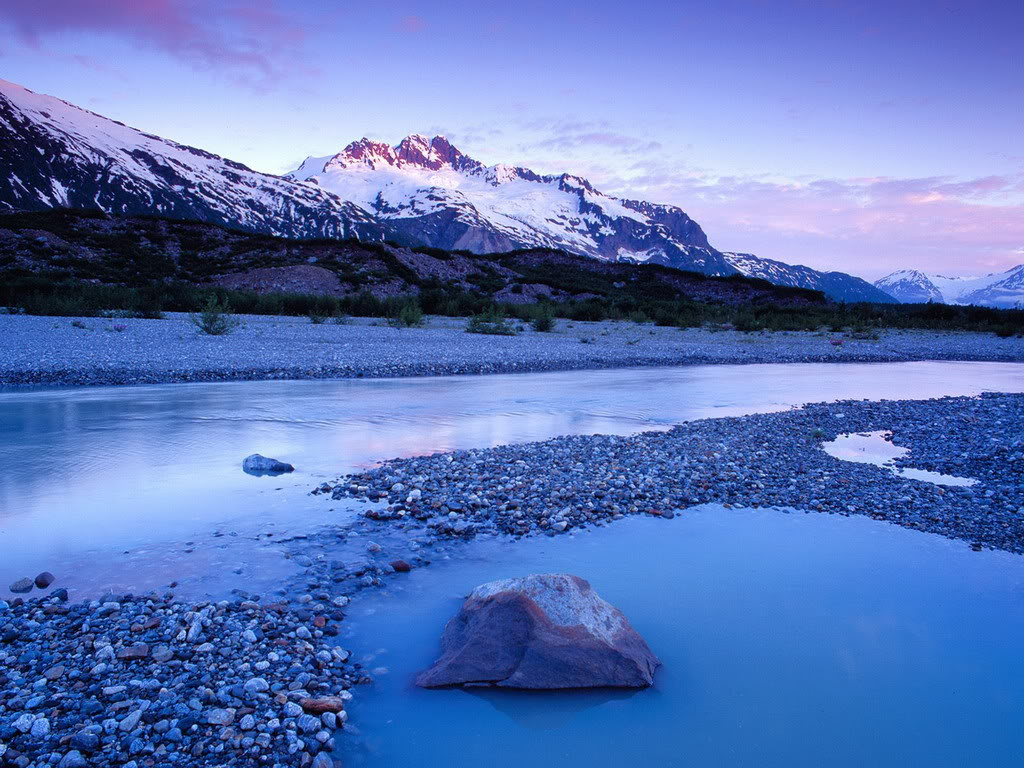

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
from IPython.display import Image, display
from google.colab import files

display(Image(filename="output.png"))
files.download("output.png")


In [19]:
!./decode output.png
!cat text1.txt

Rank 0 - Decode Kernel Time: 0.000000 sec
Rank 1 - Decode Kernel Time: 0.000000 sec
Rank 2 - Decode Kernel Time: 0.000000 sec
Rank 3 - Decode Kernel Time: 0.000000 sec
Message decoded and saved to decoded_message.txt
Clemson Tigers are fierce and passionate competitors. 
From the stadium to the classroom to the research lab, Tigers play to win. 
Our academic programs are rigorous and challenging, but  that's what makes a Clemson degree so valuable. 
Research, a focus on serving our community, rigorous academics, high caliber faculty, spirited family. 
Its all in a days work,
